# パターン認識論レポート課題１    B4TB2047 小倉 康睦

In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as la
from itertools import product
from matplotlib import pyplot as plt

# 1. 判別評価基準 (ユークリッド・類似度・重みつきユークリッド距離)

## Nearest Neighbor

In [2]:
def nearest_neighbor(class1, class2, test):
    met = np.zeros((test.shape[0], class1.shape[1]))
    result = np.zeros(test.shape[0], dtype='int')
    for k, t in enumerate(test):
        p_t = t[:2]
        
        min_dist1 = min(np.linalg.norm(class1 - p_t, axis=1))
        min_dist2 = min(np.linalg.norm(class2 - p_t, axis=1))
        met[k][0] = min_dist1
        met[k][1] = min_dist2
        if min_dist1 <= min_dist2:
            result[k] = 1
        else:
            result[k] = 2
    return met, result

def get_border_points(xs, ys, result):
    border_x = []
    border_y = []
    for i in range(1, result.shape[0]):
        for j in range(1, result.shape[1]):
            if (result[i][j] != result[i-1][j]) or (result[i][j] != result[i][j-1]):
                border_x.append((xs[j-1] + xs[j]) / 2)
                border_y.append((ys[i-1] + ys[i]) / 2)
    return (border_x, border_y)
    
def plot_border_nearest_neighbor(class1, class2, test, axis):
    xmin = np.floor(axis[0])
    xmax = np.ceil(axis[1])
    ymin = np.floor(axis[2])
    ymax = np.ceil(axis[3])
    
    step = 0.1
    ys = np.arange(ymin, ymax, step)
    xs = np.arange(xmin, xmax, step)
    buf = []
    for y in ys:
        ps = np.zeros((len(xs), 2))
        ps[:, 0] = xs
        ps[:, 1] = y
        buf.append(ps)
    X = np.concatenate(buf, axis=0)
    _, result = nearest_neighbor(class1, class2, X)
    result = result.reshape((len(ys), len(xs)))
    border_x, border_y = get_border_points(xs, ys, result)
    
    plt.scatter(border_x, border_y, label='border', s=1)

## ユークリッド距離

In [3]:
def euclid(class1, class2, test):
    met = np.zeros((test.shape[0], class1.shape[1]))
    result = np.zeros(test.shape[0], dtype='int')

    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    for k, t in enumerate(test):
        p_t = t[:2]
        
        min_dist1 = np.linalg.norm(mean1 - p_t)
        min_dist2 = np.linalg.norm(mean2 - p_t)
        met[k][0] = min_dist1
        met[k][1] = min_dist2
        if min_dist1 <= min_dist2:
            result[k] = 1
        else:
            result[k] = 2
    return met, result

def plot_border_euclid(class1, class2, axis):
    xmin = np.floor(axis[0])
    xmax = np.ceil(axis[1])
    ymin = np.floor(axis[2])
    ymax = np.ceil(axis[3])

    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    c = (mean1 + mean2) / 2
    t = mean1 - mean2
    m = -1 * (t[0] / t[1])
    # y = m(x - c[0]) + c[1]
    
    px = np.array([xmin, xmax])
    py = m * (px - c[0]) + c[1]
    plt.scatter(mean1[0], mean1[1], s=500, marker='*', label='mean1')
    plt.scatter(mean2[0], mean2[1], s=500, marker='*', label='mean2')
    plt.plot(px, py, label='border')

## 類似度（コサイン類似度）

In [4]:
def similarity(class1, class2, test):
    met = np.zeros((test.shape[0], class1.shape[1]))
    result = np.zeros(test.shape[0], dtype='int')

    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    for k, t in enumerate(test):
        p_t = t[:2]
        
        min_dist1 = p_t.dot(mean1) / (np.linalg.norm(p_t) * np.linalg.norm(mean1))
        min_dist2 = p_t.dot(mean2) / (np.linalg.norm(p_t) * np.linalg.norm(mean2))
        met[k][0] = min_dist1
        met[k][1] = min_dist2
        if (1 - min_dist1) <= (1 - min_dist2):
            result[k] = 1
        else:
            result[k] = 2
    return met, result

def plot_border_similarity(class1, class2, axis):
    xmin = np.floor(axis[0])
    xmax = np.ceil(axis[1])
    ymin = np.floor(axis[2])
    ymax = np.ceil(axis[3])

    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    theta1 = np.arctan(mean1[1] / mean1[0])
    theta2 = np.arctan(mean2[1] / mean2[0])
    m = np.tan((theta1 + theta2) / 2)
    
    px = np.array([xmin, xmax])
    py = m * px
    plt.scatter(mean1[0], mean1[1], s=500, marker='*', label='mean1')
    plt.scatter(mean2[0], mean2[1], s=500, marker='*', label='mean2')
    plt.plot(px, py, label='border')

## 重み付きユークリッド距離

### 重み付きユークリッド距離の尺度は行列$W = diag(w)$によって定まる線形変換$W^{\frac{1}{2}}$によってデータを写像した空間では通常のユークリッド距離と等価になる。

In [5]:
def weighted_euclid(w, class1, class2, test):
    W = np.diag(np.sqrt(w))

    met = np.zeros((test.shape[0], class1.shape[1]))
    result = np.zeros(test.shape[0], dtype='int')

    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    for k, t in enumerate(test):
        p_t = t[:2]
        
        min_dist1 = np.linalg.norm(W.dot(mean1 - p_t))
        min_dist2 = np.linalg.norm(W.dot(mean2 - p_t))
        met[k][0] = min_dist1
        met[k][1] = min_dist2
        if min_dist1 <= min_dist2:
            result[k] = 1
        else:
            result[k] = 2
    return met, result

def plot_border_weighted_euclid(class1, class2, axis, w):
    W = np.diag(np.sqrt(w))
    W_inv = np.diag(1 / np.sqrt(w))
    
    xmin = np.floor(axis[0])
    xmax = np.ceil(axis[1])
    ymin = np.floor(axis[2])
    ymax = np.ceil(axis[3])

    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    wmean1 = W.dot(mean1)
    wmean2 = W.dot(mean2)
    c = (wmean1 + wmean2) / 2
    t = wmean1 - wmean2
    m = -1 * (t[0] / t[1])
    # y = m(x - c[0]) + c[1]
    
    wpx = W[0][0] * np.array([xmin, xmax])
    wpy = m * (wpx - c[0]) + c[1]
    
    # 元の空間への引き戻し
    px = W_inv[0][0] * wpx
    py = W_inv[1][1] * wpy
    
    plt.scatter(mean1[0], mean1[1], s=500, marker='*', label='mean1')
    plt.scatter(mean2[0], mean2[1], s=500, marker='*', label='mean2')
    plt.plot(px, py, label='border')

In [6]:
def plot_border(method, class1, class2, test, axis, w=None):
    if method == 'nearest':
        plot_border_nearest_neighbor(class1, class2, test, axis)
    elif method == 'euclid':
        plot_border_euclid(class1, class2, axis)
    elif method == 'similarity':
        plot_border_similarity(class1, class2, axis)
    elif method == 'weighted_euclid':
        plot_border_weighted_euclid(class1, class2, axis, w)

In [7]:
# datファイルの読み込み
def read_table(path):
    with open(path) as f:
        lines = f.readlines()
    
    buf = []
    for line in lines:
        buf.append(list(map(float, line.split())))
        
    return np.array(buf)

# 散布図の表示
def plot_clusters(class1, class2, test, title, labels, method, w=None, subplot=None):
    if method not in ['nearest', 'euclid', 'similarity', 'weighted_euclid', 'pca']:
        print('No such method')
        return

    if subplot is not None:
        plt.subplot(subplot[0], subplot[1], subplot[2])
    plt.title(title)
    plt.scatter(class1[:,0], class1[:,1], label=labels[0])
    plt.scatter(class2[:,0], class2[:,1], label=labels[1])
    test1 = test[test[:,2] == 1]
    test2 = test[test[:,2] == 2]
    plt.scatter(test1[:,0], test1[:,1], label=labels[2])
    plt.scatter(test2[:,0], test2[:,1], label=labels[3])
    axis = plt.axis()
    plot_border(method, class1, class2, test, axis, w)
    plt.xlim(axis[:2])
    plt.ylim(axis[2:])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(loc='lower right')
    if subplot is None:
        plt.legend(loc='upper right', bbox_to_anchor=(0.8, 0.8, 0.5, .100), borderaxespad=0.,)
        plt.show()

# 結果の出力
def print_result(met, result, test, print_all=True, output_path=None):
    buf = []
    buf.append('NUM    MET1    MET2   RES   ANS  o/x')
    buf.append('------------------------------------')
    template = '{:>3d}   {:5.2f}   {:5.2f}   {:>3d}   {:>3d}    {:1s} '
    correct = 0
    for k in range(len(result)):
        if len(test.shape) == 1:
            tans = int(test[k])
        else:
            tans = int(test[k][2])
        if result[k] == tans:
            c = 'o'
            correct += 1
        else:
            c = 'x'
        buf.append(template.format(k+1, met[k][0], met[k][1], result[k], tans, c))
    rate_str = ('------- recog. rate = {:4.2f} --------'.format(correct / test.shape[0] * 100))
    buf.append(rate_str)
    
    if output_path is not None:
        with open(output_path, 'w') as f:
            for line in buf:
                f.write(line)
                f.write('\n')
    
    if print_all:
        for line in buf:
            print(line)
    else:
        print(rate_str)
    
    return

In [8]:
class1_A = read_table('data/2D-class1_A.dat')
class2_A = read_table('data/2D-class2_A.dat')
test_A = read_table('data/2D-test_A.dat')
setA = [class1_A, class2_A, test_A]

class1_B = read_table('data/2D-class1_B.dat')
class2_B = read_table('data/2D-class2_B.dat')
test_B = read_table('data/2D-test_B.dat')
setB = [class1_B, class2_B, test_B]

class1_C = read_table('data/2D-class1_C.dat')
class2_C = read_table('data/2D-class2_C.dat')
test_C = read_table('data/2D-test_C.dat')
setC = [class1_C, class2_C, test_C]

class1_D = read_table('data/2D-class1_D.dat')
class2_D = read_table('data/2D-class2_D.dat')
test_D = read_table('data/2D-test_D.dat')
setD = [class1_D, class2_D, test_D]

課題(b)には

> 学習データ(2D-class1_A.dat、2D-class2_A.dat)、テストデータ(2D-test_A.dat(正解クラスごと に点のタイプを変えること)) の 2 次元散布図を作成せよ。その際に、学習データの平均もプロットし、 学習データの散布図から、それぞれの評価基準における識別境界 (直線または区分的直線) を求め図示 せよ。但し、Nearest Neighbor については、おおまかなもので良い。その結果より、各評価基準においてテストデータの誤認識が起こる領域について述べよ。

とあるので、Nearest Neighbor, ユークリッド距離、類似度、重み付きユークリッド距離のそれぞれについて分析していく。ただしNearest Neighborに限っては学習データの平均は特に意味はないのでプロットしない。

## Nearest Neighbor

In [9]:
met_A, result_A = nearest_neighbor(class1_A, class2_A, test_A)
print_result(met_A, result_A, test_A, print_all=True, output_path='result/resultA_NN.txt')

met_B, result_B = nearest_neighbor(class1_B, class2_B, test_B)
print_result(met_B, result_B, test_B, print_all=True, output_path='result/resultB_NN.txt')

met_C, result_C = nearest_neighbor(class1_C, class2_C, test_C)
print_result(met_C, result_C, test_C, print_all=True, output_path='result/resultC_NN.txt')

met_D, result_D = nearest_neighbor(class1_D, class2_D, test_D)
print_result(met_D, result_D, test_D, print_all=True, output_path='result/resultD_NN.txt')

NUM    MET1    MET2   RES   ANS  o/x
------------------------------------
  1    2.26   11.45     1     1    o 
  2    6.92   11.78     1     1    o 
  3    2.87   20.10     1     1    o 
  4    5.13   13.93     1     1    o 
  5    2.88   24.24     1     1    o 
  6    1.85   14.70     1     1    o 
  7    7.40   24.77     1     1    o 
  8    7.65   17.29     1     1    o 
  9    2.37   24.75     1     1    o 
 10    2.87   15.96     1     1    o 
 11    7.87    0.66     2     1    x 
 12    4.01   32.34     1     1    o 
 13    4.07    4.38     1     1    o 
 14    3.66   15.72     1     1    o 
 15    3.13   16.84     1     1    o 
 16    8.04   24.05     1     1    o 
 17    7.20    8.63     1     1    o 
 18    7.14    3.55     2     1    x 
 19    6.19   32.25     1     1    o 
 20   12.69   12.16     2     1    x 
 21    9.88    3.02     2     2    o 
 22    9.15    2.98     2     2    o 
 23    0.38    4.32     1     2    x 
 24   21.65    2.06     2     2    o 
 25   21.57   

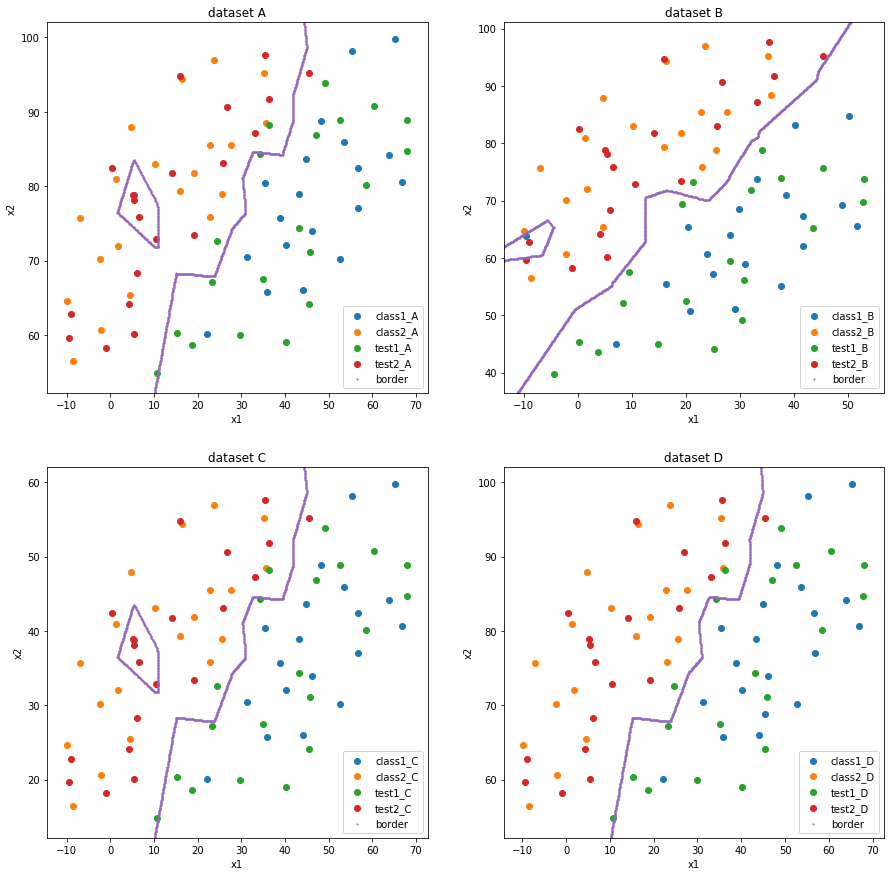

In [10]:
plt.figure(figsize=(15,15))
plot_clusters(class1_A, class2_A, test_A, 'dataset A', ['class1_A', 'class2_A', 'test1_A', 'test2_A'], method='nearest', subplot=(2,2,1))
plot_clusters(class1_B, class2_B, test_B, 'dataset B', ['class1_B', 'class2_B', 'test1_B', 'test2_B'], method='nearest', subplot=(2,2,2))
plot_clusters(class1_C, class2_C, test_C, 'dataset C', ['class1_C', 'class2_C', 'test1_C', 'test2_C'], method='nearest', subplot=(2,2,3))
plot_clusters(class1_D, class2_D, test_D, 'dataset D', ['class1_D', 'class2_D', 'test1_D', 'test2_D'], method='nearest', subplot=(2,2,4))
plt.show()

### 誤認識が発生するのは、相手側にめりこんでしまっている外れ値の島の部分、および識別境界付近の両クラスの点が混在している領域である。

## ユークリッド距離

In [11]:
met_A, result_A = euclid(class1_A, class2_A, test_A)
print_result(met_A, result_A, test_A, print_all=True, output_path='result/resultA_EUC.txt')

met_B, result_B = euclid(class1_B, class2_B, test_B)
print_result(met_B, result_B, test_B, print_all=True, output_path='result/resultB_EUC.txt')

met_C, result_C = euclid(class1_C, class2_C, test_C)
print_result(met_C, result_C, test_C, print_all=True, output_path='result/resultC_EUC.txt')

met_D, result_D = euclid(class1_D, class2_D, test_D)
print_result(met_D, result_D, test_D, print_all=True, output_path='result/resultD_EUC.txt')

NUM    MET1    MET2   RES   ANS  o/x
------------------------------------
  1    8.40   36.09     1     1    o 
  2   35.25   18.93     2     1    x 
  3    7.58   34.83     1     1    o 
  4   15.69   40.12     1     1    o 
  5   13.29   46.66     1     1    o 
  6   15.16   25.86     1     1    o 
  7   19.34   49.95     1     1    o 
  8   24.33   26.12     1     1    o 
  9   14.52   36.68     1     1    o 
 10    4.76   31.68     1     1    o 
 11   13.11   26.18     1     1    o 
 12   23.36   56.30     1     1    o 
 13   12.40   23.07     1     1    o 
 14   33.25   21.46     2     1    x 
 15   12.56   41.91     1     1    o 
 16   20.28   34.61     1     1    o 
 17   24.81   16.42     2     1    x 
 18   21.67   14.13     2     1    x 
 19   24.86   56.98     1     1    o 
 20   42.12   24.14     2     1    x 
 21   19.95   14.59     2     2    o 
 22   31.31    3.60     2     2    o 
 23   40.21    6.77     2     2    o 
 24   56.65   26.45     2     2    o 
 25   50.66   

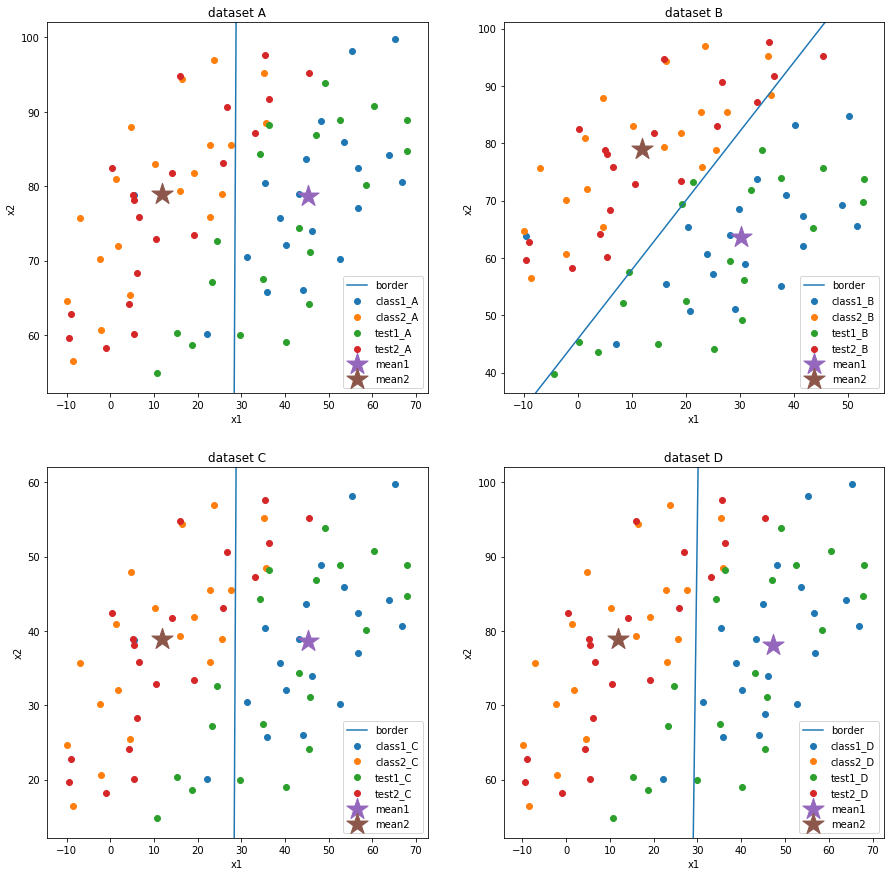

In [12]:
plt.figure(figsize=(15,15))
plot_clusters(class1_A, class2_A, test_A, 'dataset A', ['class1_A', 'class2_A', 'test1_A', 'test2_A'], method='euclid', subplot=(2,2,1))
plot_clusters(class1_B, class2_B, test_B, 'dataset B', ['class1_B', 'class2_B', 'test1_B', 'test2_B'], method='euclid', subplot=(2,2,2))
plot_clusters(class1_C, class2_C, test_C, 'dataset C', ['class1_C', 'class2_C', 'test1_C', 'test2_C'], method='euclid', subplot=(2,2,3))
plot_clusters(class1_D, class2_D, test_D, 'dataset D', ['class1_D', 'class2_D', 'test1_D', 'test2_D'], method='euclid', subplot=(2,2,4))
plt.show()

### そもそも各クラスの分散（点の広がりの方向）を無視して識別境界を引くため、識別境界と点の広がる方向がズレている場合は一部またいでしまい、誤認識する。

## 類似度

In [13]:
met_A, result_A = similarity(class1_A, class2_A, test_A)
print_result(met_A, result_A, test_A, print_all=True, output_path='result/resultA_SIM.txt')

met_B, result_B = similarity(class1_B, class2_B, test_B)
print_result(met_B, result_B, test_B, print_all=True, output_path='result/resultB_SIM.txt')

met_C, result_C = similarity(class1_C, class2_C, test_C)
print_result(met_C, result_C, test_C, print_all=True, output_path='result/resultC_SIM.txt')

met_D, result_D = similarity(class1_D, class2_D, test_D)
print_result(met_D, result_D, test_D, print_all=True, output_path='result/resultD_SIM.txt')

NUM    MET1    MET2   RES   ANS  o/x
------------------------------------
  1    1.00    0.94     1     1    o 
  2    0.96    1.00     2     1    x 
  3    1.00    0.91     1     1    o 
  4    1.00    0.95     1     1    o 
  5    0.99    0.89     1     1    o 
  6    1.00    0.95     1     1    o 
  7    1.00    0.91     1     1    o 
  8    1.00    0.95     1     1    o 
  9    1.00    0.89     1     1    o 
 10    1.00    0.93     1     1    o 
 11    0.99    0.97     1     1    o 
 12    0.99    0.86     1     1    o 
 13    0.99    0.97     1     1    o 
 14    0.98    0.99     2     1    x 
 15    1.00    0.93     1     1    o 
 16    1.00    0.90     1     1    o 
 17    0.98    0.98     2     1    x 
 18    0.98    0.98     2     1    x 
 19    0.99    0.88     1     1    o 
 20    0.95    1.00     2     1    x 
 21    0.98    0.99     2     2    o 
 22    0.94    1.00     2     2    o 
 23    0.90    1.00     2     2    o 
 24    0.79    0.96     2     2    o 
 25    0.86   

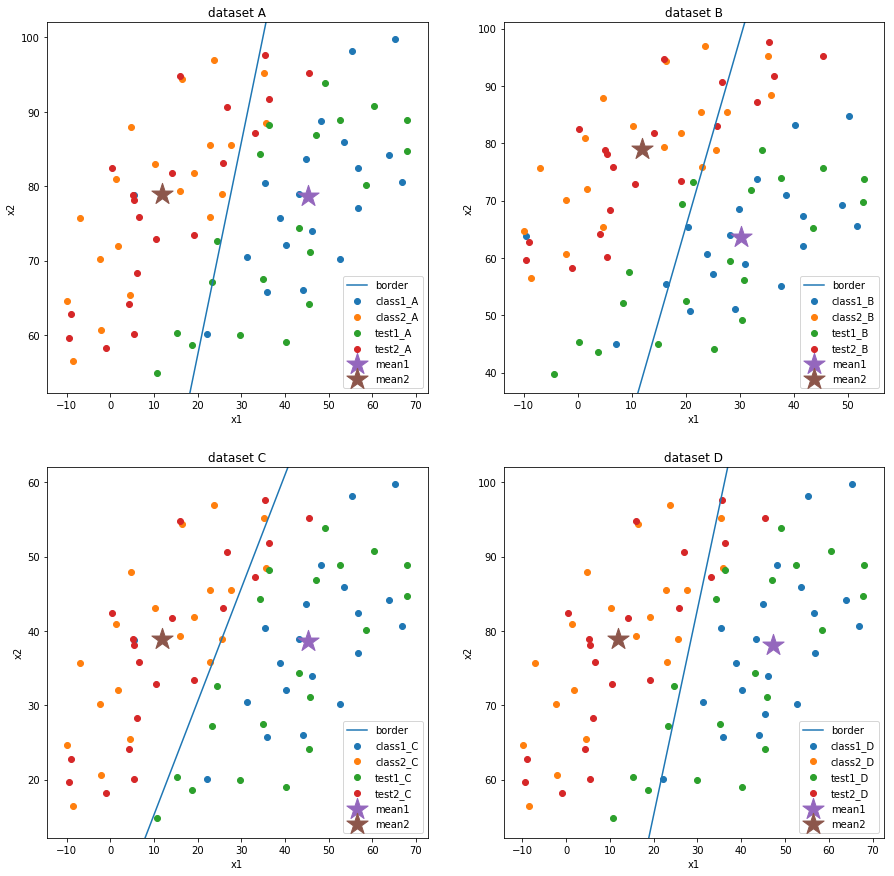

In [14]:
plt.figure(figsize=(15,15))
plot_clusters(class1_A, class2_A, test_A, 'dataset A', ['class1_A', 'class2_A', 'test1_A', 'test2_A'], method='similarity', subplot=(2,2,1))
plot_clusters(class1_B, class2_B, test_B, 'dataset B', ['class1_B', 'class2_B', 'test1_B', 'test2_B'], method='similarity', subplot=(2,2,2))
plot_clusters(class1_C, class2_C, test_C, 'dataset C', ['class1_C', 'class2_C', 'test1_C', 'test2_C'], method='similarity', subplot=(2,2,3))
plot_clusters(class1_D, class2_D, test_D, 'dataset D', ['class1_D', 'class2_D', 'test1_D', 'test2_D'], method='similarity', subplot=(2,2,4))
plt.show()

### ユークリッド距離のときと同様に、識別境界を引くときに各クラスの分散は考慮せずに原点を通る直線を引くから、ユークリッド距離のときと同様の問題が起こる。今回はたまたまうまくいっているだけだと考えられる。

## 重み付きユークリッド距離

In [15]:
w = np.array([1, 90])

met_A, result_A = weighted_euclid(w, class1_A, class2_A, test_A)
print_result(met_A, result_A, test_A, print_all=True, output_path='result/resultA_WEUC.txt')

met_B, result_B = weighted_euclid(w, class1_B, class2_B, test_B)
print_result(met_B, result_B, test_B, print_all=True, output_path='result/resultB_WEUC.txt')

met_C, result_C = weighted_euclid(w, class1_C, class2_C, test_C)
print_result(met_C, result_C, test_C, print_all=True, output_path='result/resultC_WEUC.txt')

met_D, result_D = weighted_euclid(w, class1_D, class2_D, test_D)
print_result(met_D, result_D, test_D, print_all=True, output_path='result/resultD_WEUC.txt')

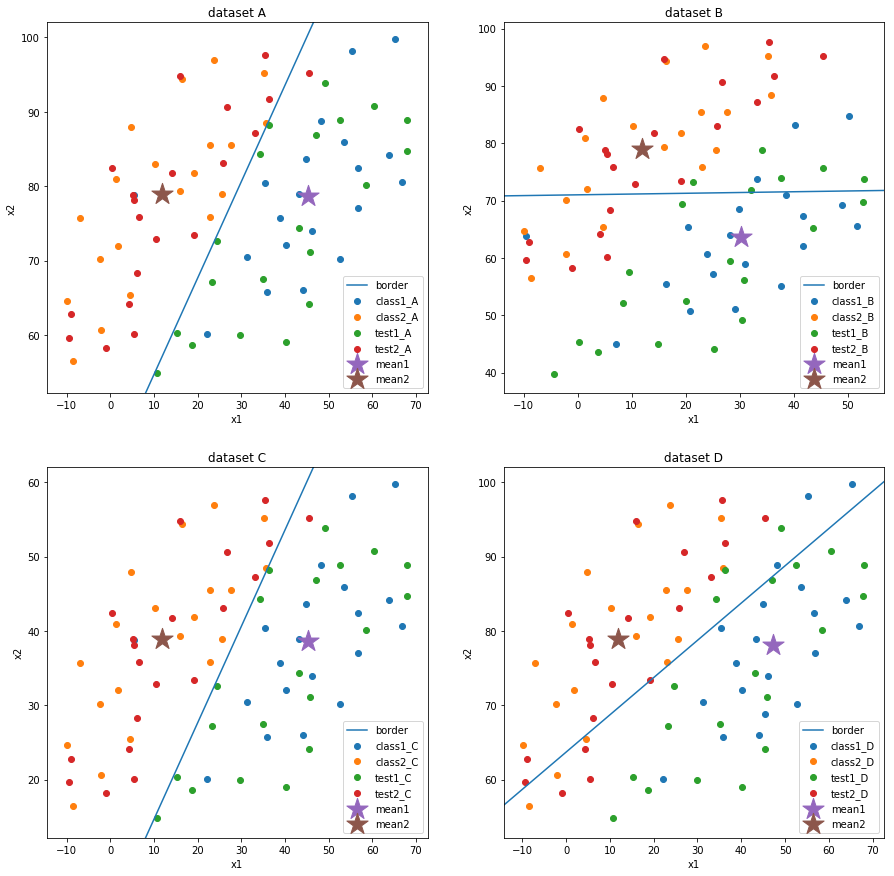

In [16]:
plt.figure(figsize=(15,15))
plot_clusters(class1_A, class2_A, test_A, 'dataset A', ['class1_A', 'class2_A', 'test1_A', 'test2_A'],
              method='weighted_euclid', w=w, subplot=(2,2,1))
plot_clusters(class1_B, class2_B, test_B, 'dataset B', ['class1_B', 'class2_B', 'test1_B', 'test2_B'],
              method='weighted_euclid', w=w, subplot=(2,2,2))
plot_clusters(class1_C, class2_C, test_C, 'dataset C', ['class1_C', 'class2_C', 'test1_C', 'test2_C'],
              method='weighted_euclid', w=w, subplot=(2,2,3))
plot_clusters(class1_D, class2_D, test_D, 'dataset D', ['class1_D', 'class2_D', 'test1_D', 'test2_D'],
              method='weighted_euclid', w=w, subplot=(2,2,4))
plt.show()

### 重み付けたとはいえ$W^\frac{1}{2}$による写像先の空間ではユークリッド距離とまったく一致しているから、ユークリッド距離のときと同様の問題が起こる。

# 2. 判別分析 (LDA)・主成分分析 (PCA)

主成分分析にせよ判別分析にせよ、「与えられたデータが母集団と一致している場合」と「与えられたデータが母集団からサンプリングされた場合」のどちらであるかによって用いる統計量は変わってきます。前者であれば分散には標本分散(=母分散)を取ればよいですし、後者であれば母分散の不偏推定量を用いるべきです（他にもベイズ推論を用いた主成分分析なども存在しますが、今回の趣旨とは異なるので採用しません）。

授業スライドにある方法は標本分散の式ですが、今回のレポートは教師データとテストデータが分かれています。すなわち教師データは明らかに「母集団からサンプリングされたもの」ですから、テストデータに対しても妥当な写像を求めるためには母分散の不偏推定量を用いるべきだと判断し、本レポートにおいては母分散の不偏推定量を採用いたします。このようにアルゴリズムを設計することで、既知のデータから得られた直交行列で新しく与えられたデータを射影してもある程度の（少なくとも標本分散を用いるよりは）妥当性が担保されるため、主成分分析に関しては、テストデータは直交行列の学習の段階では未知のものとして扱った上で「テストデータの識別率」を測定いたします。

numpyのcov関数はデフォルトで母分散の不偏推定量を返します。すなわち中心化された教師データ$X$のデータ数が$N$であるとき（中心化はもちろん内部で行われます）、
$$
C = \frac{ X X^T}{N-1}
$$を返します。教師データ数が非常に大きくなる場合には標本分散と母分散の不偏推定量はほぼ一致しますが、今回のレポート程度の規模のデータセットだとまず一致することはありません。採点者が標本分散を用いて模範解答を作成していた場合、本レポートの実行結果とは微妙に異なる可能性があります。その場合はお手数ですが母分散の不偏推定量を用いてご確認いただくようよろしくお願いいたします。

また、判別分析の「クラス間分散」はそういった統計の概念では扱いにくい尺度であり、判別分析はクラス内分散とクラス間分散の定義を揃えるためにどうしても標本分散によらざるを得ません。したがって「一度判別分析に用いた固有ベクトルで新しく与えられたデータを射影する」ようなことは厳密には行うべきではないので、教師データとテストデータを結合し、ひとつの母集団として扱った上で「全体の識別率」、すなわち教師データに対して再分類を行った結果を測定いたします。

## 判別分析

In [17]:
def lda(class1, class2):
    all = np.concatenate([class1, class2], axis=0)
    m = np.mean(all, axis=0)
    m1 = np.mean(class1, axis=0)
    m2 = np.mean(class2, axis=0)
    
    centered1 = class1 - m1
    centered2 = class2 - m2
    cm1 = m1[:,np.newaxis] - m[:,np.newaxis]
    cm2 = m2[:,np.newaxis] - m[:,np.newaxis]
    
    Cw = (centered1.T.dot(centered1) + centered2.T.dot(centered2)) / all.shape[0]
    
    Cb = (cm1.dot(cm1.T) + cm2.dot(cm2.T)) / all.shape[0]
    
    lam, V = la.eig(Cw, Cb)
    return (m, lam, V)

In [18]:
def reclustering(class1, class2):
    m1 = np.mean(class1)
    m2 = np.mean(class2)
    
    all = np.concatenate([class1, class2])
    met = np.zeros((len(all), 2))
    result = np.zeros(len(all), dtype='int')
    for k, x in enumerate(all):
        dist1 = np.sqrt((x - m1) ** 2)
        dist2 = np.sqrt((x - m2) ** 2)
        met[k][0] = dist1
        met[k][1] = dist2
        if dist1 <= dist2:
            result[k] = 1
        else:
            result[k] = 2
    
    return (met, result)

def plot_lda(class1, class2):
    plt.scatter(new1_A, np.zeros(len(class1)), label='class1 truth')
    plt.scatter(new2_A, np.zeros(len(class2)), label='class2 truth')
    axis = plt.axis()

    m1 = np.mean(class1)
    m2 = np.mean(class2)
    
    c = (m1 + m2) / 2
    
    axis = plt.axis()
    _, _, ymin, ymax = axis
    plt.scatter([m1], [0], s=500, marker='*', label='mean1')
    plt.scatter([m2], [0], s=500, marker='*', label='mean2')
    plt.plot([c, c], [ymin, ymax], label='border')
    plt.xlim(axis[:2])
    plt.ylim(axis[2:])
    plt.legend()
    plt.title('LDA')

In [19]:
# 教師データとテストデータを結合
test1_A = test_A[test_A[:,2] == 1][:,:2]
test2_A = test_A[test_A[:,2] == 2][:,:2]
all1_A = np.concatenate([class1_A, test1_A], axis=0)
all2_A = np.concatenate([class2_A, test2_A], axis=0)

# LDAを行う直交行列を取得し座標変換
m, _, X = lda(all1_A, all2_A)
new1_A = all1_A.dot(X[:,0])
new2_A = all2_A.dot(X[:,0])

# 識別率の測定
correct = np.concatenate([np.ones(len(new1_A)), 2 * np.ones(len(new2_A))])
met_lda, result_lda = reclustering(new1_A, new2_A)
print_result(met_lda, result_lda, correct, print_all=True, output_path='result/resultD.txt')

NUM    MET1    MET2   RES   ANS  o/x
------------------------------------
  1    1.30   23.88     1     1    o 
  2   14.43   37.01     1     1    o 
  3    3.84   18.74     1     1    o 
  4    5.94   28.52     1     1    o 
  5    4.60   17.98     1     1    o 
  6    1.27   23.85     1     1    o 
  7   28.14    5.56     2     1    x 
  8    8.36   30.94     1     1    o 
  9    7.89   14.69     1     1    o 
 10    0.09   22.49     1     1    o 
 11    2.12   20.46     1     1    o 
 12    2.63   25.21     1     1    o 
 13    9.86   32.44     1     1    o 
 14    3.31   19.27     1     1    o 
 15    1.21   21.37     1     1    o 
 16    3.13   19.45     1     1    o 
 17    6.12   16.46     1     1    o 
 18    4.27   26.86     1     1    o 
 19   11.63   34.21     1     1    o 
 20    9.73   32.31     1     1    o 
 21    4.04   18.54     1     1    o 
 22    8.24   14.34     1     1    o 
 23    6.09   28.67     1     1    o 
 24    7.49   15.09     1     1    o 
 25    8.82   

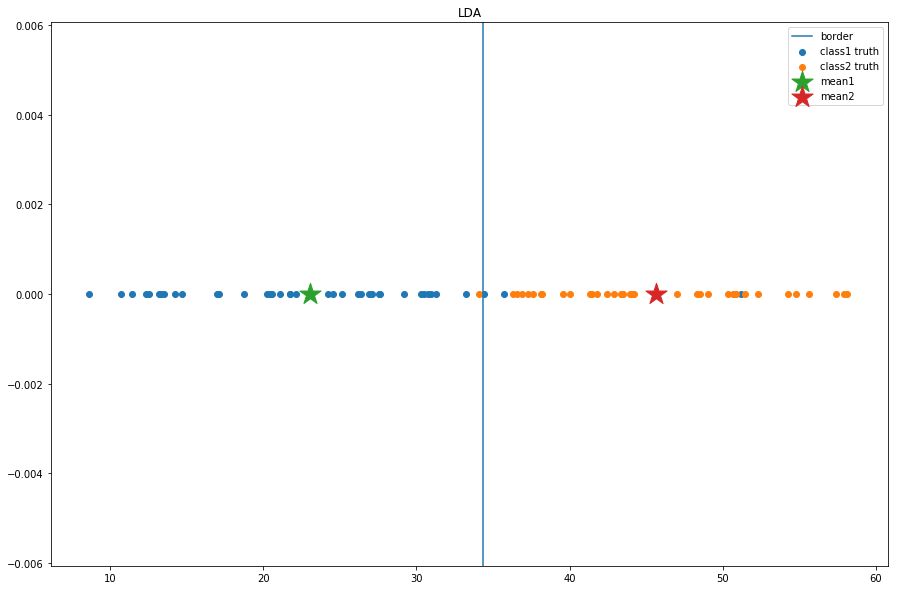

In [20]:
# プロット
plt.figure(figsize=(15,10))
plot_lda(new1_A, new2_A)
plt.show()

### 判別分析はクラス内分散を最小化し、クラス間分散を最大化するような写像であるから、それにしたがった結果が得られている。つまり1次元に圧縮してもクラスを識別しうるような情報が極力保存されているので、うまく識別境界を引くことができる。識別率は$95$%と高い。

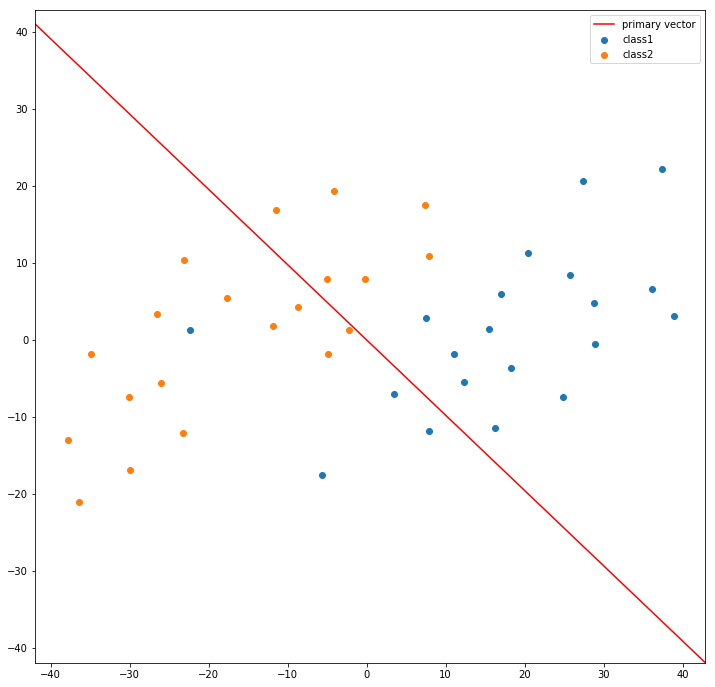

In [21]:
plt.figure(figsize=(12,12))
# 中心化
m_class1_A = class1_A - m
m_class2_A = class2_A - m
plt.scatter(m_class1_A[:,0], m_class1_A[:,1], label='class1')
plt.scatter(m_class2_A[:,0], m_class2_A[:,1], label='class2')
x1 = 200 * X[:,0]
axis = plt.axis()
plt.plot([-x1[0], x1[0]], [-x1[1], x1[1]], color='r', label='primary vector')
plt.xlim(axis[:2])
plt.ylim(axis[:2])
plt.legend()
plt.show()

## 主成分分析

In [22]:
def pca(class1, class2):
    X = np.concatenate([class1, class2], axis=0)
    m = np.mean(X, axis=0)
    C = np.cov(X.T)
    lam, V = la.eig(C)
    return (m, lam, V)

In [23]:
def clustering(class1, class2, test):
    m1 = np.mean(class1)
    m2 = np.mean(class2)
    
    met = np.zeros((test.shape[0], 2))
    result = np.zeros(test.shape[0], dtype='int')
    for k, x in enumerate(test[:,0]):
        dist1 = np.sqrt((x - m1) ** 2)
        dist2 = np.sqrt((x - m2) ** 2)
        met[k][0] = dist1
        met[k][1] = dist2
        if dist1 <= dist2:
            result[k] = 1
        else:
            result[k] = 2
    
    return (met, result)

def plot_pca(class1, class2, test):
    plt.scatter(class1, np.zeros(len(class1)), label='class1')
    plt.scatter(class2, np.zeros(len(class2)), label='class2')
    axis = plt.axis()

    m1 = np.mean(class1)
    m2 = np.mean(class2)
    
    c = (m1 + m2) / 2
    
    axis = plt.axis()
    _, _, ymin, ymax = axis
    
    test1 = test[test[:,2] == 1]
    test2 = test[test[:,2] == 2]
    plt.scatter(test1[:,0], test1[:,1], label='test1')
    plt.scatter(test2[:,0], test2[:,1], label='test2')
    plt.scatter([m1], [0], s=500, marker='*', label='mean1')
    plt.scatter([m2], [0], s=500, marker='*', label='mean2')
    plt.plot([c, c], [ymin, ymax], label='border')
    plt.xlim(axis[:2])
    plt.ylim(axis[2:])
    plt.legend()
    plt.title('PCA')

In [24]:
m, _, X = pca(class1_A, class2_A)
new_class1_A = (class1_A - m).dot(X)
new_class2_A = (class2_A - m).dot(X)
new_test = np.concatenate([test_A[:,:2].dot(X), test_A[:,2][:,np.newaxis]], axis=1)

In [25]:
# 1次元に削減した上でクラスタリング
met_pca, result_pca = clustering(new_class1_A[:,0], new_class2_A[:,0], new_test)
print_result(met_pca, result_pca, new_test, print_all=True, output_path='result/resultD.txt')

NUM    MET1    MET2   RES   ANS  o/x
------------------------------------
  1   49.58   82.06     1     1    o 
  2   12.46   44.94     1     1    o 
  3   44.71   77.19     1     1    o 
  4   53.17   85.65     1     1    o 
  5   59.17   91.65     1     1    o 
  6   33.42   65.90     1     1    o 
  7   63.45   95.93     1     1    o 
  8   26.55   59.03     1     1    o 
  9   42.75   75.23     1     1    o 
 10   42.95   75.43     1     1    o 
 11   39.45   71.93     1     1    o 
 12   69.32   101.80     1     1    o 
 13   36.57   69.05     1     1    o 
 14   15.53   48.01     1     1    o 
 15   55.40   87.88     1     1    o 
 16   36.47   68.95     1     1    o 
 17   21.93   54.41     1     1    o 
 18   24.33   56.81     1     1    o 
 19   70.38   102.86     1     1    o 
 20    6.69   39.17     1     1    o 
 21   28.06   60.54     1     2    x 
 22   16.35   48.83     1     2    x 
 23    6.89   39.37     1     2    x 
 24   10.60   21.88     1     2    x 
 25    3.85 

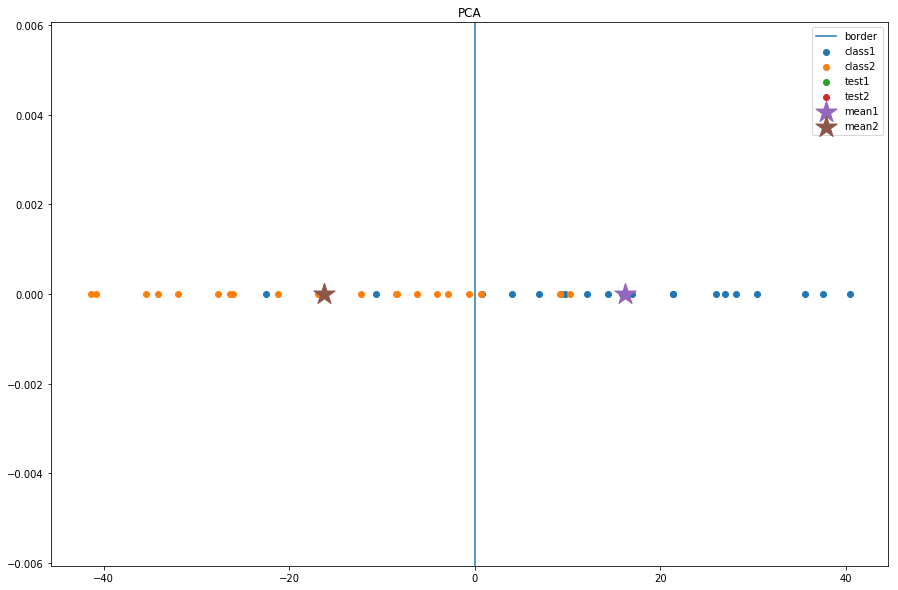

In [26]:
# プロット
plt.figure(figsize=(15,10))
plot_pca(new_class1_A[:,0], new_class2_A[:,0], new_test)
plt.show()

### 主成分分析は全体の分散が最大であるような方向を求めるような写像であるから、クラスを識別しやすくなるような情報は取り出されていない。識別率は$50$%であって判別分析よりもはるかに小さい。なぜならば（事前確率にもよるが）識別率$50$%とは「あてずっぽうで1か2を言って当たる確率」と同じだからである。

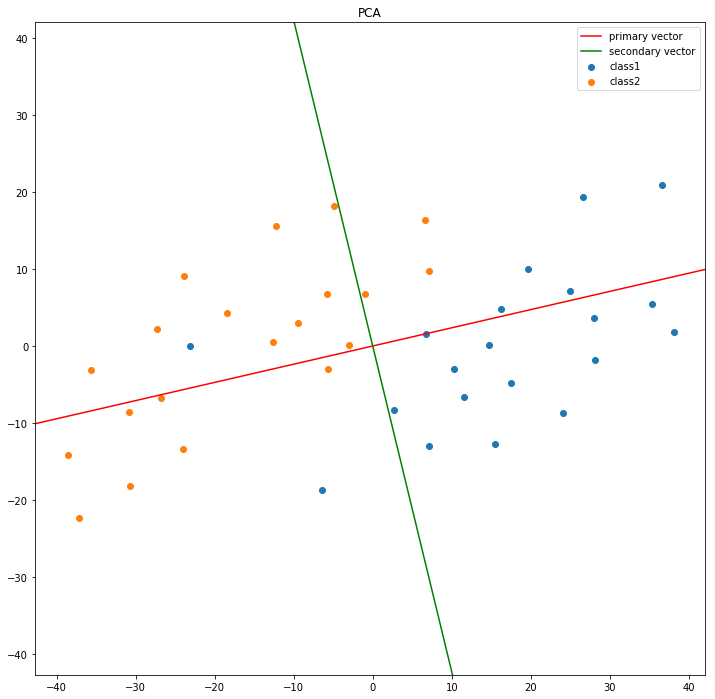

In [27]:
plt.figure(figsize=(12,12))
# 中心化
m_class1_A = class1_A - m
m_class2_A = class2_A - m
plt.scatter(m_class1_A[:,0], m_class1_A[:,1], label='class1')
plt.scatter(m_class2_A[:,0], m_class2_A[:,1], label='class2')
x1 = 200 * X[:,0]
x2 = 200 * X[:,1]
axis = plt.axis()
plt.plot([-x1[0], x1[0]], [-x1[1], x1[1]], color='r', label='primary vector')
plt.plot([-x2[0], x2[0]], [-x2[1], x2[1]], color='g', label='secondary vector')
plt.xlim(axis[:2])
plt.ylim(axis[:2])
plt.title('PCA')
plt.legend()
plt.show()